# Creating a dataset

This tutorial provides a short example on how to create a SeisBench dataset. Datasets can be created from any event catalog and waveform collection. For this example, we download an event catalog for Switzerland through FDSN. We will then download the associated waveforms through FDSN as well. We use built-in SeisBench functions for writing out the dataset in SeisBench format. In this example notebook we aim for an easy example outlining the principles of dataset creation. There are a few further considerations, in particular, for converting larger datasets, that we outline at the end.

**Note:** Some familiarity with obspy and its FDSN client is helpful for this tutorial, but not required.

In [1]:
import seisbench.data as sbd
import seisbench.util as sbu

import matplotlib.pyplot as plt
from pathlib import Path
from obspy import read_events
from obspy import read
from obspy import Stream
import numpy as np

#### The event catalog

As a first step, we need an event catalog. Here, we are going to use the catalog provided by ETHZ over FDSN. For demonstration purposes, we only use a short time window.

In [3]:
path_base = '/home/ekarkooti/Documents'
path_catalog = f'{path_base}/Kaki-test/*.CAT'
path_stream = f"{path_base}/Kaki/raw-gcf-data/"
path_output = f'{path_base}/Kaki-test'

In [3]:
catalog = read_events(path_catalog)

/home/ekarkooti/Application/python-env/SeisBench_v0.5.3/lib/python3.10/site-packages/obspy/io/nordic/utils.py:184: UserWarning: Lines of type I have not been implemented yet, please submit a development request
  warnings.warn("Lines of type %s have not been implemented yet, "


In [4]:
# print(catalog.__str__(print_all=True))
print(catalog)

1 Event(s) in Catalog:
2013-04-23T04:38:51.500000Z | +28.426,  +51.690 | 1.5  ML


In [5]:
catalog = [ev for ev in catalog if ev.picks != []]
print(len(catalog))

1


#### Extracting the event parameters

From the catalog, we extract the event parameters and store them into a dictionary. Here, we only extract a few basic parameters on the source and its magnitude - if available. In addition, we define the split of the dataset into training/development/test partitions. We visualize one example.

In [6]:
def get_event_params(event):
    origin = event.preferred_origin()
    mag = event.preferred_magnitude()

    source_id = str(event.resource_id)

    event_params = {
        "source_id": source_id,
        "source_origin_time": str(origin.time),
        "source_origin_uncertainty_sec": origin.time_errors["uncertainty"],
        "source_latitude_deg": origin.latitude,
        "source_latitude_uncertainty_km": origin.latitude_errors["uncertainty"],
        "source_longitude_deg": origin.longitude,
        "source_longitude_uncertainty_km": origin.longitude_errors["uncertainty"],
        "source_depth_km": origin.depth / 1e3            if origin.depth else None,
        "source_depth_uncertainty_km": origin.depth_errors["uncertainty"] / 1e3           if origin.depth else None,
    }

    if mag is not None:
        event_params["source_magnitude"] = mag.mag
        event_params["source_magnitude_uncertainty"] = mag.mag_errors["uncertainty"]
        event_params["source_magnitude_type"] = mag.magnitude_type
        event_params["source_magnitude_author"] = mag.creation_info.agency_id

        if str(origin.time) < "2015-01-07":
            split = "train"
        elif str(origin.time) < "2015-01-08":
            split = "dev"
        else:
            split = "test"
        event_params["split"] = split
    return event_params

# print(catalog[0].preferred_magnitude() is not None)
# get_event_params(catalog[0])

#### Extracting the trace parameters

From each pick, we extract parameters about the trace and store them in a dictionary. Again, we only extract very basic parameters. We visualize one example.

In [7]:
def get_trace_params(pick):
    net = pick.waveform_id.network_code
    sta = pick.waveform_id.station_code

    trace_params = {
        "station_network_code": net,
        "station_code": sta,
        "trace_channel": pick.waveform_id.channel_code[:2],
        "station_location_code": pick.waveform_id.location_code,
    }

    return trace_params

# get_trace_params(catalog[0].picks[0])

#### Downloading the waveforms

As a last step, we need to access the waveforms. As for the catalog, we download the waveforms from ETHZ via FDSN. Note that not for all picks we can expect to have waveforms available through FDSN, so we just return empty streams if no data is available. We visualize one example.

In [8]:
def rename_stream_mapper(obspy_stream, networks, stations, locations, channels):
    for tr in obspy_stream:
        tr.stats.network = networks[tr.stats.network]
        tr.stats.station = stations[tr.stats.station]
        tr.stats.location = locations[tr.stats.location]
        tr.stats.channel = channels[tr.stats.channel]

def reversing_dictionary(dictionary):
    return {v:k for k, v in dictionary.items()}

networks = {'': ''}
stations = {'6210': 'HANA',# 6210-Hana-shour  
            '6249': 'SORM',# 6249-Sarmak ??? SORM
            '6260': 'CHAH',# 6260-Chahgah     
            '6270': 'LAVA',# 6270-Lavar
            '6215': 'JASH',# 6215-Jashk       
            '6251': 'SANA',# 6251-Sana              
            '6261': 'SHON',# 6261-Shonbeh     
            '6289': 'ABDA',# 6289-Abdan
            '6218': 'KERD',# 6218-Kerdelan    
            '6252': 'BONY',# 6252-Bonyad            
            '6266': 'KARD',# 6266-Kardaneh
            '6219': 'DOHO',# 6219-Dohouk      
            '6255': 'BOBM',# 6255-Babmonir          
            '6268': 'ESLA',# 6268-Eslam-Abad
            '6226': 'BAGH',# 6226-Baghan      
            '6259': 'GENK',# 6259-Genkhak-Sheikhha  
            '6270': 'DARV',# 6270-drveshei
            }


locations = {'': ''}
# channels = {'HHZ': 'SZ',
#             'HHN': 'SN',
#             'HHE': 'SE'}
channels = {'HHZ': 'HHZ',
            'HHN': 'HHN',
            'HHE': 'HHE'}

In [9]:
stationsr = reversing_dictionary(stations)
# station_code = stationsr.get('SORM', None)
# station_code

In [10]:
def get_waveforms(pick, root):
    stationsr = reversing_dictionary(stations)
    station_code = stationsr.get(pick.waveform_id.station_code)
    if station_code==None:
        print(f'Station Not Found.\n{pick.waveform_id.station_code}\n')
        with open('reading-data-problem.txt', 'a') as f:
            f.write(f'Station Not Found.\n{pick.waveform_id.station_code}\n')
        return Stream()
    time = pick.time.strftime('%Y%m%d_%H')
    st = Stream()
    for channel in ['e', 'n', 'z']:
        path_data = f'{root}/{station_code}*/gcf/{time}00{channel}.gcf'
        try:
            st += read(path_data)
        except Exception as error:
            print(f'Skip Data.\n{error}\n{path_data}\n')
            with open('reading-data-problem.txt', 'a') as f:
                f.write(f'Skip Data.\n{error}\n{path_data}\n')
    # st_trim = st.slice(starttime=pick.time-time_before,
    #                    endtime=pick.time+time_after)
    
    return st


In [11]:
def trim_data(st, pick, before, after):
    st.trim(starttime=pick.time-before,
            endtime=pick.time+after,
            pad=True,
            nearest_sample=True,
            fill_value=0) 

In [12]:
def preprocessing_data(st):
    st.merge(-1)
    st.detrend('constant')
    st.merge(fill_value=0)


#### Writing to SeisBench format

Now, we can combine all the above functions together to write a dataset in SeisBench format. For this, we first need to define the path. For this example, we are using the current working directory. A dataset consists of 2 components:
 - a metadata file, always called `metadata.csv`, which contains all the associated properties of the waveform examples (e.g. trace parameters, source parameters etc.).
 - a waveforms file, always called `waveforms.hdf5`, containing the raw waveforms.

In [5]:
base_path = Path(path_output)
metadata_path = base_path / "metadata.csv"
waveforms_path = base_path / "waveforms.hdf5"

To write the dataset, we use the `WaveformDataWriter` provided by SeisBench. The writer should always be used as a context manager, i.e., using the `with` statement, as shown below. This is to ensure files are properly clsoed after writing and teardown and cleanup operations are always called when exiting the context manager.

First, we need to set the data format for our dataset. We do this by assigning a dictionary to the `writer.data_format` group.

Next, we iterate over all event and all picks in the events. Using the functions above, we generate the event and trace metadata and download the waveforms. We then convert the waveforms to a numpy array using the function `stream_to_array` provided in `seisbench.util`.

As a last step, we hand the event metadata and the waveforms as numpy array over to the writer using `add_trace`. The writer then automatically takes care of writing out the data in the correct format. It also takes care of performance optimisations that we outline in the further considerations below.

In [14]:
def select_picks(picks, station_name):
    picks = [pick for pick in picks
             if pick.waveform_id.station_code==station_name]
    picks = sorted(picks,
                   key= lambda p: p.time)
    return picks
    

In [15]:
def get_picks_time_difference(picks):
    picks_time = [pick.time for pick in picks]
    picks_time = sorted(picks_time)
    picks_difftime = [time-picks_time[0] for time in picks_time]
    return picks_difftime

In [16]:
def checking_equal_sps(stream):
    sps = stream[0].stats.sampling_rate
    assert all(tr.stats.sampling_rate == sps for tr in stream)

In [50]:
before = 5
duration = 30


In [61]:
# Iterate over events and picks, write to SeisBench format
with sbd.WaveformDataWriter(metadata_path, waveforms_path) as writer:

    # Define data format
    writer.data_format = {
        "dimension_order": "CW",
        "component_order": "ZNE",
        "measurement": "velocity",
        "unit": "counts",
        "instrument_response": "not restituted",
    }
    n_all = len(catalog)
    for index, event in enumerate(catalog):
        # if index < 1050:
        #     continue
        if index % 50 == 0:
            print(f'{index} of {n_all} {index/n_all:.2f}%')
            # if index == 100:
            #     break

        event_params = get_event_params(event)
        stations_in_event = {pick.waveform_id.station_code for pick in event.picks}
        for station_name in stations_in_event:
            picks = select_picks(picks=event.picks,
                                 station_name=station_name)
            ###
            time_diff = get_picks_time_difference(picks)
            if max(time_diff) >= 60:
                print(f'losing pick, maximume is: {max(time_diff)}')
            ###
            pick = picks[0]
            trace_params = get_trace_params(pick)
            waveforms = get_waveforms(pick, path_stream)
            ### Preprocessing waveform
            rename_stream_mapper(waveforms, networks, stations, locations, channels)
            preprocessing_data(st=waveforms)
            random = np.random.uniform(-before/2, before/2)
            trim_data(waveforms, pick, before=before-random, after=duration-before+random)
            ### Check remaining data
            if len(waveforms) == 0:
                # No waveform data available
                continue
            ###
            sampling_rate = waveforms[0].stats.sampling_rate
            # Check that the traces have the same sampling rate
            checking_equal_sps(stream=waveforms)

            actual_t_start, data, _ = sbu.stream_to_array(
                waveforms,
                component_order=writer.data_format["component_order"],
            )
            trace_params["trace_sampling_rate_hz"] = sampling_rate
            trace_params["trace_start_time"] = str(actual_t_start)

            for pick in picks:
                sample = (pick.time - actual_t_start) * sampling_rate
                trace_params[f"trace_{pick.phase_hint}_arrival_sample"] = int(sample)
                trace_params[f"trace_{pick.phase_hint}_status"] = pick.evaluation_mode

            writer.add_trace({**event_params, **trace_params}, data)

0 of 1 0.00%


Traces converted: 3it [00:00, 17.49it/s]

Skip Data.
failure to decode data block 2 (last data != RIC)
/home/ekarkooti/Documents/Kaki/raw-gcf-data//6259*/gcf/20130423_0400n.gcf



Traces converted: 11it [00:00, 12.28it/s]


### Loading the dataset

Now that the dataset conversion is finished, we can check it by simply loading it. Here we load the dataset, print the metadata and visualize the first waveform together with the annotated pick.

In [6]:
data = sbd.WaveformDataset(base_path, sampling_rate=100)

In [7]:
print("Training examples:", len(data.train()))
print("Development examples:", len(data.dev()))
print("Test examples:", len(data.test()))

Training examples: 11
Development examples: 0
Test examples: 0


In [8]:
targets = [key for key in data.metadata.keys() if 'arrival' in key]
data.metadata[targets]
# data.metadata.keys()

,trace_Pg_arrival_sample,trace_Sg_arrival_sample,trace_AML_arrival_sample
0,270,NaN,NaN
1,539,NaN,NaN
2,316,NaN,NaN
3,271,471.0,473.0
4,348,NaN,769.0
5,457,NaN,NaN
6,598,858.0,NaN
7,530,802.0,NaN
8,574,NaN,NaN
9,302,649.0,703.0


(3, 3001)
(3, 3001)
(3, 3001)
(3, 3001)
(3, 3001)
(3, 3001)
(3, 3001)
(3, 3001)
(3, 3001)
(3, 3001)
(3, 3001)


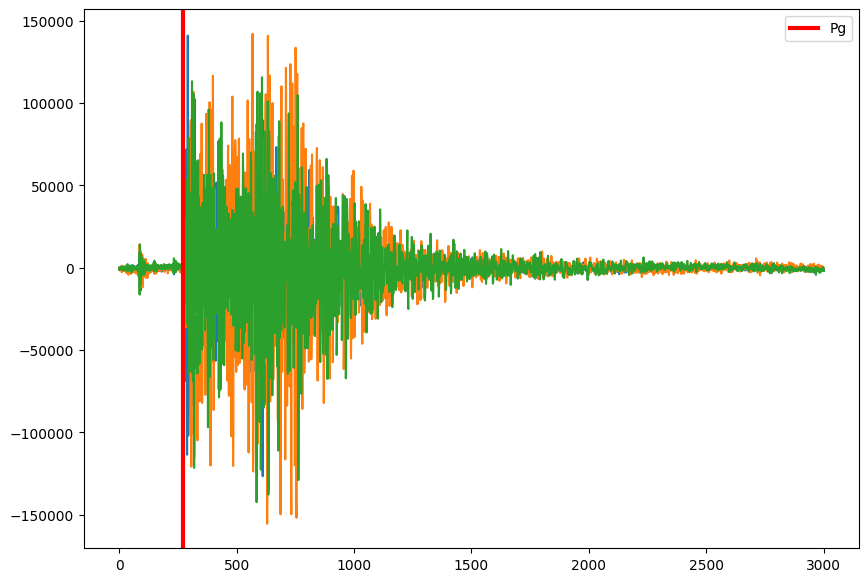

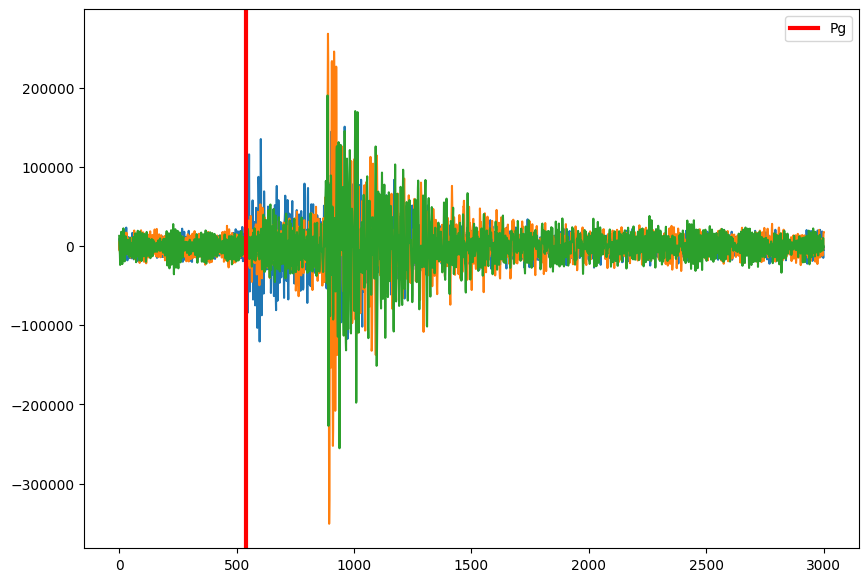

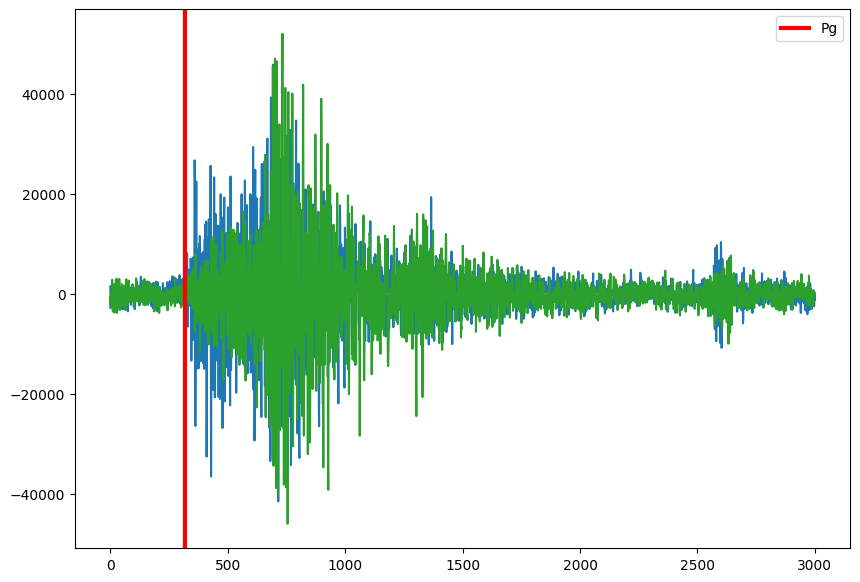

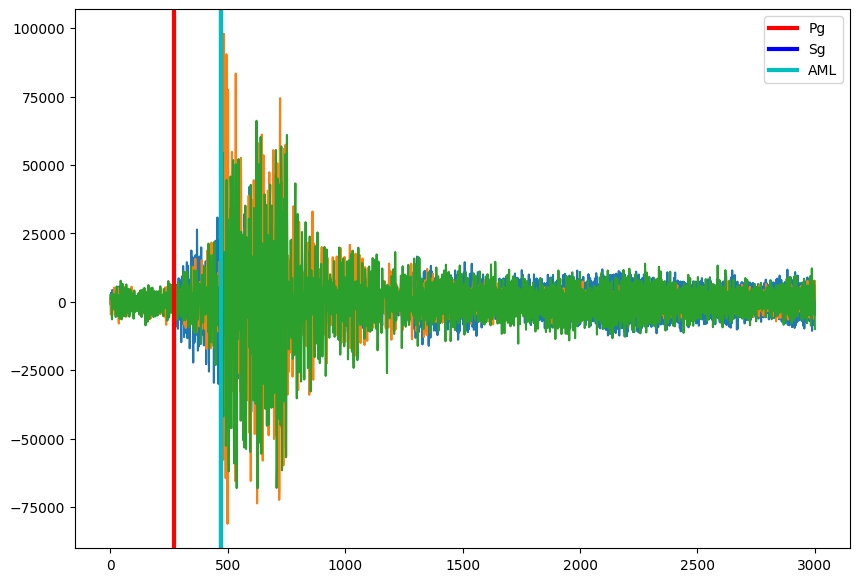

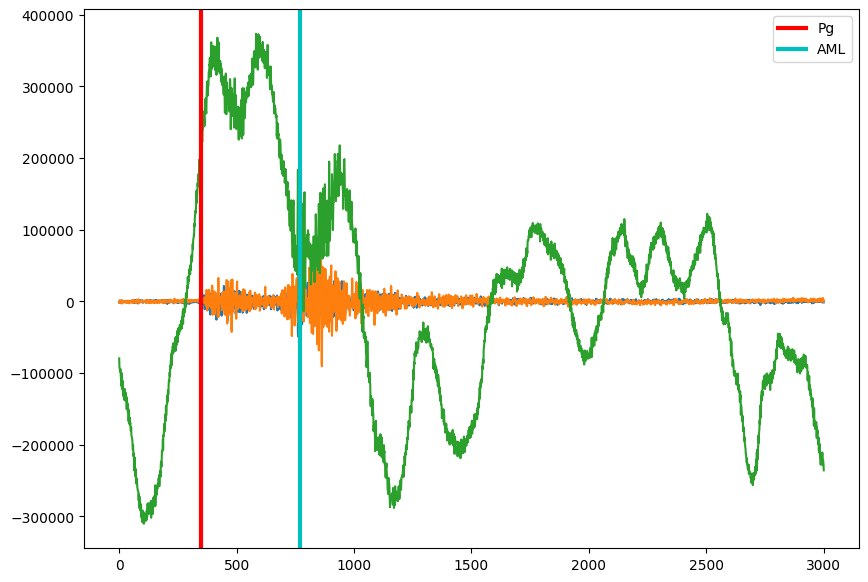

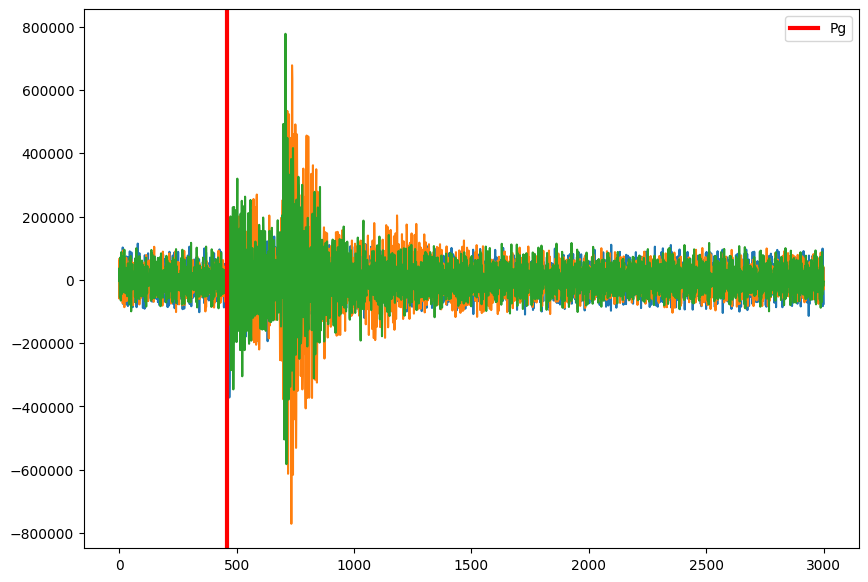

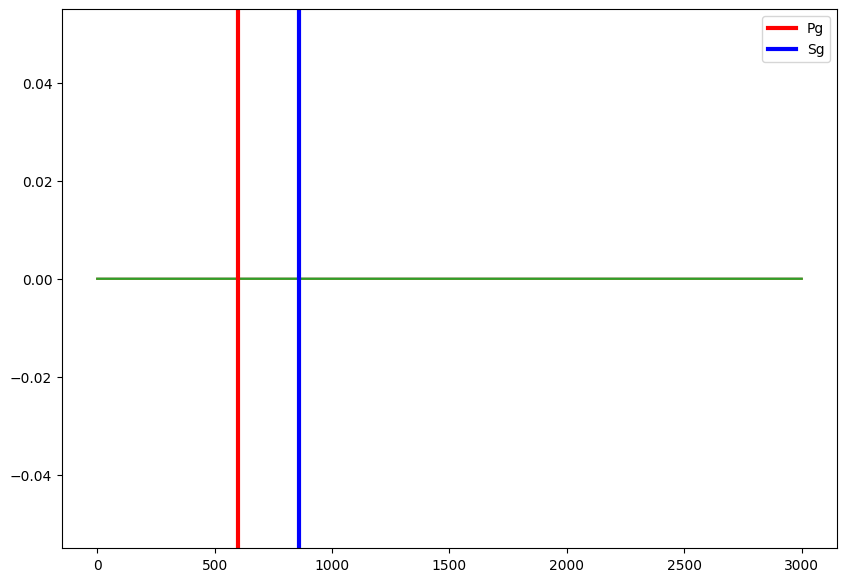

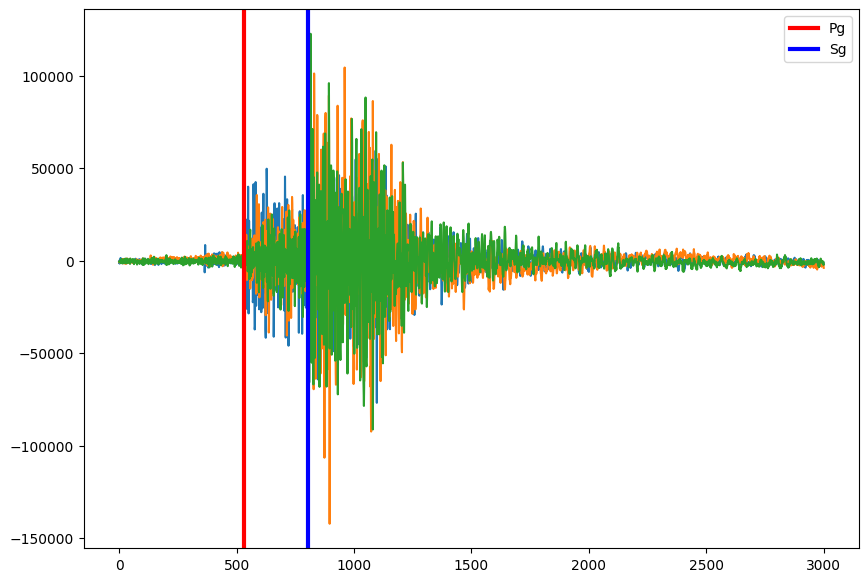

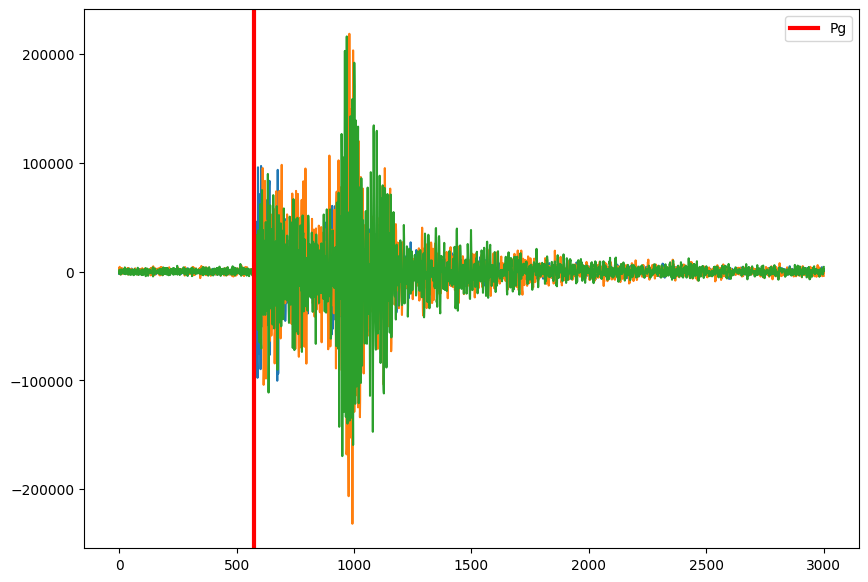

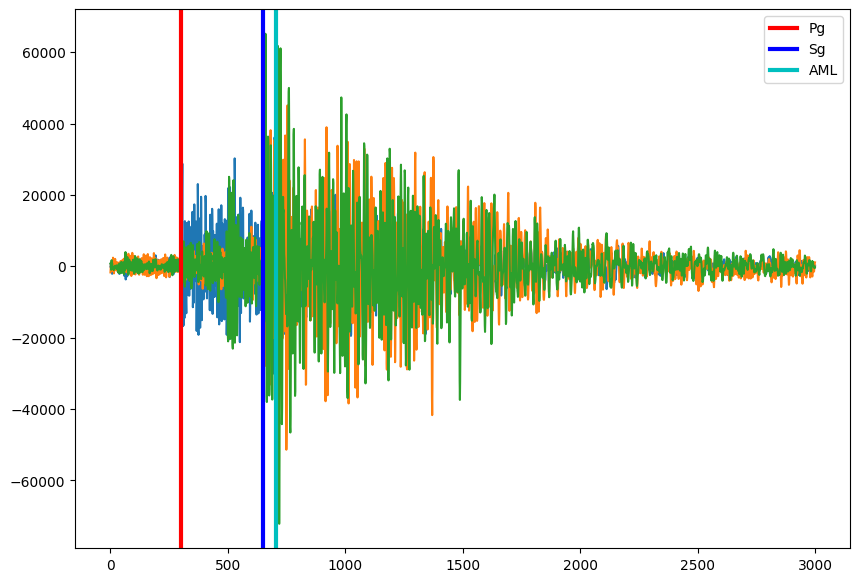

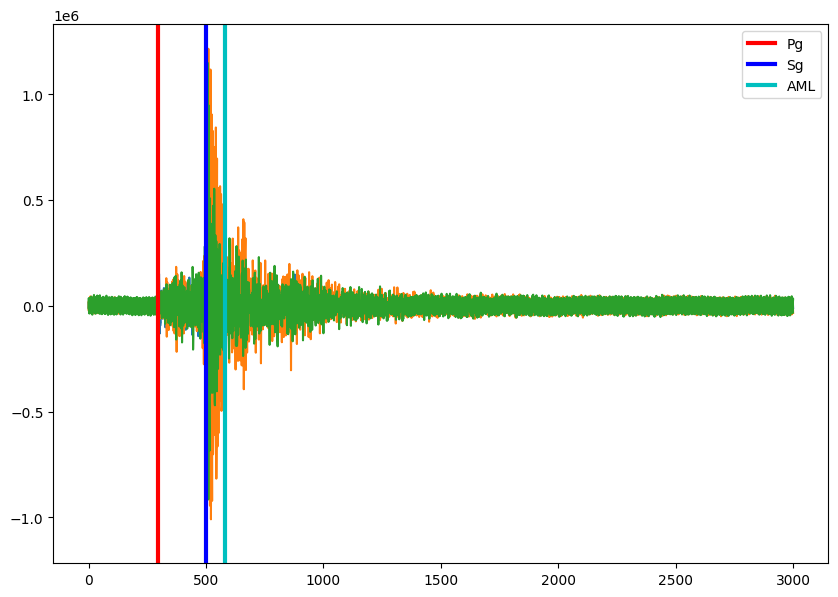

In [9]:
def cmap(phase_hint):
    c = {'Pg': 'r', 'Sg': 'b', 'AML': 'c'}
    return c.get(phase_hint, 'y')

for ii, metadata in data.metadata.iterrows():
    # print(metadata)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    trace = data.get_waveforms(ii)
    print(trace.shape)
    ax.plot(trace.T)
    targets = [key for key in metadata.keys() if 'arrival' in key]
    targets = [key for key in targets if not np.isnan(metadata[key])]
    # print(targets, metadata[targets])
    for target in targets:
        phase_hint = target.split('_')[1]
        ax.axvline(metadata[target], lw=3, c=cmap(phase_hint), label=phase_hint)
    plt.legend()

## Considerations for converting datasets

As outlined above, this tutorial provides a very minimal example on converting a dataset. Here we outline additional consideration that should be taken into account when preparing a dataset.

- **Grouping picks**: In this example, we created one trace for each pick. Naturally, traces will overlap if multiple picks, e.g., P and S phases, are available for an event at a station. For an example implementation of this grouping operation, have a look [here](https://github.com/seisbench/seisbench/blob/df94dcd86ce66d6a2ee2bd00da3857259fe579bd/seisbench/data/ethz.py#L109) and in the subsequent lines.
- **Adding station information**: In this example, we added no station information except its name. In practice, it will often be helpful for users to incorporate, for example, the location of the station. We skipped this step here, because it requires loading station inventories through FDSN. For an example implementation, have a look [here](https://github.com/seisbench/seisbench/blob/df94dcd86ce66d6a2ee2bd00da3857259fe579bd/seisbench/data/ethz.py#L315).
- **Memory requirements**: Internally, the `WaveformDataWriter` writes out the the waveforms continuously in blocks (see point below), but keeps all metadata in memory until the dataset is complete. For very large datasets (or very detailed metadata) this can result in several gigabytes of memory consumption. If you are writing such datasets, make sure the available memory on your machine is sufficient.
- **Waveform blocks**: Instead of writing each waveform separately, waveforms are written out in blocks. This massively improves IO performance. Have a look at [the documentation](https://seisbench.readthedocs.io/en/stable/pages/data_format.html#traces-blocks) for details on the strategy. We expect that in nearly all cases using the default setting will be a good choice.
- **FDSN considerations**: When converting very large datasets, the performance might be limited by the performance of the FDSN webservice. Unfortunately, downloading lots of short waveforms (as required for many machine learning applications) does not seem to be the most favorable use case for FDSN. This leads to rather slow performance when naively downloading the waveforms as outlined above. Instead, it is often helpful to issue [bulk requests](https://docs.obspy.org/master/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms_bulk.html). In addition, it might be a good choice to first download the waveforms and cache them locally, for example, in .mseed format, and then convert them to SeisBench.

For further details on the data format, check out [the data format specification in the SeisBench documentation](https://seisbench.readthedocs.io/en/stable/pages/data_format.html#traces-blocks).

(3, 3001)


(400.0, 2000.0)

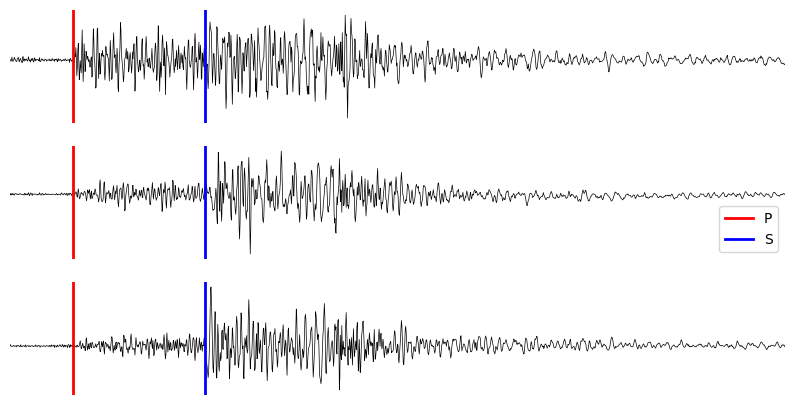

In [31]:
def cmap(phase_hint):
    c = {'Pg': 'r', 'Sg': 'b', 'AML': 'c'}
    return c.get(phase_hint, 'y')

ii = 7
metadata = data.metadata.iloc[ii]
# print(metadata)
fig, axes = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
trace = data.get_waveforms(ii)
print(trace.shape)
for jj in range(3):
    axes[jj].plot(trace.T[:, jj], c='k', lw=0.5)
    axes[jj].patch.set_visible(False)
    axes[jj].axis('off')
targets = [key for key in metadata.keys() if 'arrival' in key]
targets = [key for key in targets if not np.isnan(metadata[key])]
# print(targets, metadata[targets])
for target in targets:
    phase_hint = target.split('_')[1]
    for jj in range(3):
        axes[jj].axvline(metadata[target], lw=2, c=cmap(phase_hint), label=phase_hint[0])
axes[1].legend()
plt.xlim([400, 2000])

In [32]:
metadata

index                                                                           7
source_id                          smi:local/c456715a-c41c-4f68-89f3-32904176bf60
source_origin_time                                    2013-04-23T04:38:51.500000Z
source_origin_uncertainty_sec                                                0.34
source_latitude_deg                                                        28.426
source_latitude_uncertainty_km                                           0.007195
source_longitude_deg                                                        51.69
source_longitude_uncertainty_km                                          0.007158
source_depth_km                                                              10.6
source_depth_uncertainty_km                                                   1.5
source_magnitude                                                              1.5
source_magnitude_uncertainty                                                  NaN
source_magnitude